# Large-Scale Network Analysis with PySpark
In this notebook, we're going to explore how we can analyze large-scale graph data using Spark's [GraphFrames package](https://graphframes.github.io/graphframes/docs/_site/index.html). Using the package, you can run graph queries and algorithms on Vertex/Edge data that is structured in the fashion of a Spark DataFrame. This framework allows you to easily implement a lot of the same distributed operations you are already comfortable performing on Spark DataFrames, but on graphs -- all without needing to move your data to a specialized graph database.

Graphs can be used for analyzing many different types of data, but where we often see them in the Social Sciences is in the form of Social Network analyses. Today, we'll explore the functionality of GraphFrames using the [Marvel Universe Social Network data that is currently hosted on Kaggle](https://www.kaggle.com/csanhueza/the-marvel-universe-social-network). This data gives us a list of edges (Marvel heroes, along with the comic books that they have appeared in), as well as vertices (a list of comic book and Marvel hero names, along with a designation of whether they are of type "comic" or type "hero"). Interestingly, despite the fact that this is a fictional network (where heroes are related to one another based on which comic books they co-occur in), scholars have found that it displays many of the traits characteristic of a real-life collaboration network [(Alberich et al. 2002)](https://arxiv.org/abs/cond-mat/0202174). This data is relatively small, but the beauty of Spark's capacity for parallelism is that it allows us to seemlessly perform the same analytical procedures on ever-growing network sizes. 

Alright, that is enough background. Let's play around with the Marvel Universe Social Network using GraphFrames! 

**Note: This notebook is meant to be run on an AWS EMR Cluster (EMR version 6.2, with Spark 3.0 installed)**.

First, let's import GraphFrames. Note that you will need to specify the `graphframes` package/version in your Spark configuration (included in our class GitHub repository and uploaded to an S3 bucket) and install the `graphframes` Python package if you haven't already (i.e. run the cells below).

In [ ]:
%%configure -f
{
    "conf": {
        "spark.jars.packages": "graphframes:graphframes:0.8.1-spark3.0-s_2.12",
        "spark.jars.repositories": "https://repos.spark-packages.org/",
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [ ]:
sc.install_pypi_package('graphframes')

In [ ]:
from graphframes import *

Then, we need to read in our edge and vertex data as Spark dataframes. Note that, in the construction of a GraphFrame, the GraphFrames package expects us to provide one DataFrame of vertices and one DataFrame of edges. You can assign whatever properties you want to these vertices and edges, but the vertices DataFrame needs to have a column named 'id' which will be used as the vertex id (here, the name of the hero or comic). Likewise, the edges DataFrame needs to have columns named 'src' and 'dst', to indicate the directed relations between pairs of vertices. Here, the edge data is structured as `comic, hero` pairs of vertex ids, so we will consider each comic to be the source and each hero to be the destination. For more details on the cryptic comic book abbreviations used for the comic ids, [you can check out the key here](https://www.chronologyproject.com/key.php).

Reading in our data and renaming our columns accordingly, we can load our vertices and edges into a GraphFrame. Note that I've uploaded the CSV files to an S3 bucket in my account in order to access them (I made them publicly accessible so you should be able to read them in as well).

In [14]:
vertices = spark.read.csv('s3://css-uchicago/nodes.csv', header=True)
edges = spark.read.csv('s3://css-uchicago/edges.csv', header=True)

vertices = vertices.withColumnRenamed('node', 'id')
edges = (edges.withColumnRenamed('comic', 'src')
              .withColumnRenamed('hero', 'dst')
        )
g = GraphFrame(vertices, edges)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

After we have our data loaded into a GraphFrame, we access information about our vertices and edges like so, and even use standard DataFrame querying strategies to perform simple queries on them:

In [5]:
# Show Vertices and Edges
g.vertices.show(5)
g.edges.show(5)

# Count number of vertices that are Marvel "heroes"
g.vertices.filter("type == 'hero'").count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|                  id| type|
+--------------------+-----+
|             2001 10|comic|
|              2001 8|comic|
|              2001 9|comic|
|24-HOUR MAN/EMMANUEL| hero|
|3-D MAN/CHARLES CHAN| hero|
+--------------------+-----+
only showing top 5 rows

+--------------------+------+
|                 dst|   src|
+--------------------+------+
|24-HOUR MAN/EMMANUEL|AA2 35|
|3-D MAN/CHARLES CHAN| AVF 4|
|3-D MAN/CHARLES CHAN| AVF 5|
|3-D MAN/CHARLES CHAN| COC 1|
|3-D MAN/CHARLES CHAN|H2 251|
+--------------------+------+
only showing top 5 rows

6439

We can also perform standard graph queries like identifying the number of degrees associated with each vertex  (i.e. the number of connections to other vertices) in our graph, as well as queries about which direction these connections occur in (in- and out-degrees). Recall that here, our edges our structured as `comic, hero` source->destination pairs, so the number of out-degrees corresponds to the number of heroes that are associated with each comic book (the number of links outward from the source). The in-degrees then refer to the number of comics associated with each hero. These queries return a DataFrame that we can perform further filtering and sorting operations over the course of our analysis.

In [6]:
# For each vertex, we can do things like find the number of degrees associated with it:
g.degrees.filter("id=='CAPTAIN AMERICA'").show()

# Or make more directed queries on our graphs: the number of heroes associated with each comic book
g.outDegrees.sort('outDegree', ascending=False).show(5)

# Query: See which heroes were associated with at least 1000 comic books
g.inDegrees.filter("inDegree >= 1000").sort('inDegree', ascending=False).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------+
|             id|degree|
+---------------+------+
|CAPTAIN AMERICA|  1334|
+---------------+------+

+------+---------+
|    id|outDegree|
+------+---------+
| COC 1|      111|
|  IW 3|       91|
|  IW 1|       90|
|H2 279|       87|
|  IW 4|       80|
+------+---------+
only showing top 5 rows

+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|SPIDER-MAN/PETER ...|    1577|
|     CAPTAIN AMERICA|    1334|
| IRON MAN/TONY STARK|    1150|
+--------------------+--------+

The GraphFrames package also includes several standard graph algorithms that you can run on your graph. For instance, one such algorithm is the Page Rank, which weighs the incoming edges to a vertex and can be seen as a metric of how relevant a vertex is in a given graph. For instance, in a social network, if someone is followed by a number of people, they'll be ranked highly via Page Rank. We can see that Captain America has the highest Page Rank in this network.

In [7]:
# Run PageRank algorithm as a weighted measure of popularity, and show results.
# Can check out more built-in algorithms in the documentation
results = g.pageRank(resetProbability=0.01, maxIter=20)
results.vertices.select("id", "pagerank").sort('pagerank', ascending=False).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|                  id|          pagerank|
+--------------------+------------------+
|     CAPTAIN AMERICA|119.00103685836787|
| IRON MAN/TONY STARK|108.18352299980174|
|HULK/DR. ROBERT BRUC|107.90673039774826|
|THING/BENJAMIN J. GR| 85.84221336893948|
|     WOLVERINE/LOGAN| 83.95760674656715|
| DR. STRANGE/STEPHEN|  81.4516492153451|
|CAPTAIN BRITAIN/BRIA| 80.72463745762181|
|DAREDEVIL/MATT MURDO| 77.63006842883645|
|THOR/DR. DONALD BLAK| 76.53790094929029|
|HUMAN TORCH/JOHNNY S| 66.54532147161126|
|PUNISHER II/FRANK CA| 66.17627864130854|
| WATSON-PARKER, MARY| 62.84384611338369|
|MR. FANTASTIC/REED R| 60.93371729347744|
|SUB-MARINER/NAMOR MA|52.540676508445934|
| INVISIBLE WOMAN/SUE| 51.78598117672056|
|   JAMESON, J. JONAH|48.072441623624215|
| FURY, COL. NICHOLAS| 47.97267268912558|
|  DRACULA/VLAD TEPES|44.221193294951995|
|ANT-MAN/DR. HENRY J.| 43.34647389818435|
|BLACK PANTHER/T'CHAL| 42.52555920893674|
+--------------------+------------

Graphframes allows you to run graph queries to find network patterns. So, for instance, we can use "network motifs" to identify unique heroes (b and c) who appeared in the same comic (a) and transform each pair of co-occuring heroes into a new "edges" DataFrame. You can read more about writing network motifs in the GraphFrames documentation.

In [8]:
# Use Network Motifs to Identify unique heroes (destinations) who appeared in the same comic (source).
hero_net = g.find("(a)-[]->(b); (a)-[]->(c)") \
            .filter("b != c") \
            .dropDuplicates()

print("Network Motif Query Output:")
hero_net.show()

print("Selecting Specifically the Co-occuring/Collaborating Heroes:")
hero_edges = hero_net.select(hero_net.b.id.alias("src"), hero_net.c.id.alias("dst"))
hero_edges.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Network Motif Query Output:
+------------------+--------------------+--------------------+
|                 a|                   b|                   c|
+------------------+--------------------+--------------------+
|   [H2 425, comic]|[AGAMEMNON III/, ...|[PROMETHEUS II, h...|
|[DRSTR3 32, comic]|    [AGAMOTTO, hero]|[WARLOCK II/ADAM ...|
|    [W2 43, comic]|      [ALBERT, hero]|[WOLVERINE/LOGAN,...|
|     [N 55, comic]|[ALEXANDER, CARRI...|      [THAKOS, hero]|
|  [GAM3 17, comic]|[ALOUETTE, GENARD...|     [FIFOLET, hero]|
|   [MK3 16, comic]|[ALRAUNE, MARLENE...|[MOON KNIGHT/MARC...|
|   [NM 7/2, comic]|     [AMINEDI, hero]|[SUPER SABRE/MART...|
|    [A 105, comic]|   [AMPHIBIUS, hero]|      [VISION, hero]|
|   [FF 370, comic]|[ANGEL DOPPELGANG...|[CAPTAIN AMERICA ...|
| [CHAMP 13, comic]|[ANGEL/WARREN KEN...|    [STRANGER, hero]|
|     [IW 6, comic]|[ANGEL/WARREN KEN...|[THING/BENJAMIN J...|
|    [X '97, comic]|[ANGEL/WARREN KEN...|[STORM/ORORO MUNR...|
|    [XF 38, comic]|[ANGEL/

After transforming our data (`hero_edges` is a DataFrame), we might want to compute further graph metrics. To do so, we can then construct another GraphFrame that focuses exclusively on the edges between heroes:

In [9]:
g_heroes = GraphFrame(vertices, hero_edges)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's say we then want to plot a portion of this new GraphFrame we constructed. To do so, we can convert a subgraph of our GraphFrame into a `networkx` graph and plot it using `matplotlib`. First, let's set up a subgraph of heroes that we want to plot. Let's focus on those heroes who have an especially high degree (>20,000):

In [10]:
g_high_degree = GraphFrame(g_heroes.degrees, hero_edges).filterVertices("degree > 20000")
g_high_degree.vertices.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+
|                  id|degree|
+--------------------+------+
|THING/BENJAMIN J. GR| 21294|
|     WOLVERINE/LOGAN| 20834|
|THOR/DR. DONALD BLAK| 22924|
| SCARLET WITCH/WANDA| 20202|
|HUMAN TORCH/JOHNNY S| 20460|
| IRON MAN/TONY STARK| 23804|
|     CAPTAIN AMERICA| 31824|
+--------------------+------+

Then, we can plot this subgraph using `matplotlib` and the `draw` function from `networkx` (after installing `networkx` and `matplotlib`, if you haven't already):

In [ ]:
sc.install_pypi_package('networkx')
sc.install_pypi_package("matplotlib==3.2.1")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

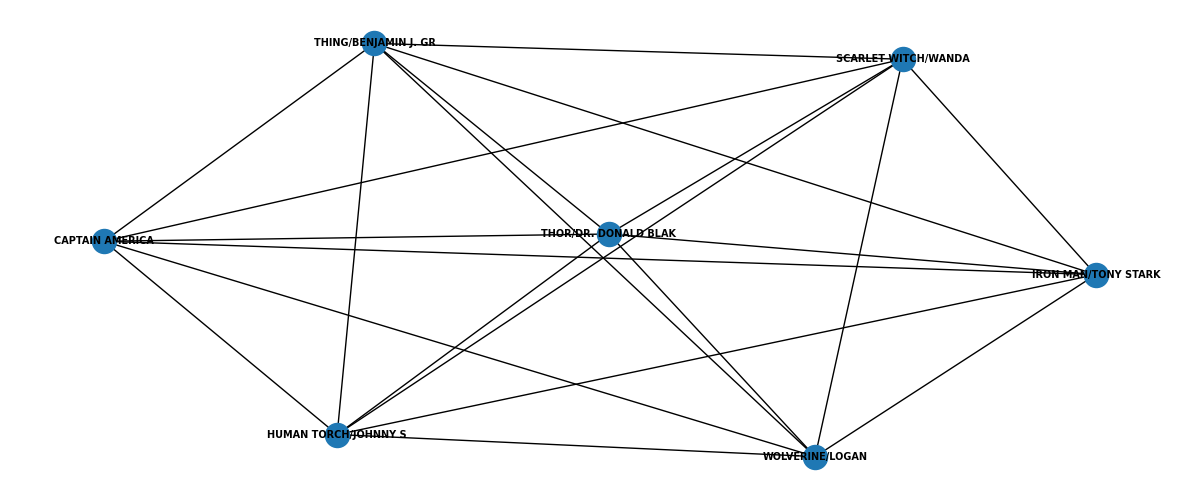

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

def PlotGraph(edge_list):
    G=nx.Graph()
    
    for row in edge_list.select('src', 'dst').collect():
        G.add_edge(row['src'], row['dst'])
    
    plt.figure(figsize=(12,5))
    nx.draw(G, 
            pos=nx.spring_layout(G), 
            with_labels=True, 
            font_weight='bold', 
            font_size=7
           )
    return

# Close previous plots; otherwise, will just overwrite and display again
plt.close()

# Plot Graph
PlotGraph(g_high_degree.edges)

%matplot plt

----
That's all for now with GraphFrames. I'll let you dig through the documentation and further explore its various querying and processing capabilities for yourself!

## Activity:

1. What are the top five comic books in terms of the number of unique collaborations that occur within them?
1. Who are the top ten most collaborative heroes overall within the the top comic book identified in the question above, as measured via their overall degree within the full collaboration network?